# Protection of personal customer data

We need to protect the data of the clients of the insurance company "Though the Flood".We develop this method of data transformation so that it is difficult to restore personal information on them, and the quality of machine learning models will not worsen.We justify the correctness of his work.The best model is not required to select the best model.

## Data load

In [30]:
# отключим предупреждающие уведомления
import warnings
warnings.filterwarnings('ignore')

# Добавим основные библиотеки
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Сделаем небольшие настройки pandas для комфортного отображения проекта
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None
plt.style.use('dark_background')

In [31]:
# Импортируем датасеты методом try/except и установим индексом столбец date
pth1 = 'datasets/insurance.csv'
pth2 = 'https://code.s3.yandex.net/datasets/insurance.csv'
    
if os.path.exists(pth1):
    df = pd.read_csv(pth1)
    print('df is loaded from the address: datasets/insurance.csv')
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
    print('df is loaded from the address: https://code.s3.yandex.net/datasets/insurance.csv')
else:
    print('error: wrong path')

df is loaded from the address: datasets/insurance.csv


In [32]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.00,49600.00,1,0
1,0,46.00,38000.00,1,1
2,0,29.00,21000.00,0,0
3,0,21.00,41700.00,2,0
4,1,28.00,26100.00,0,0


Since the column names are in Russian, let's rename them

In [33]:
df.rename(columns={'Пол': 'Gender',
                   'Возраст': 'Age',
                   'Зарплата': 'Salary',
                   'Члены семьи': 'Family members',
                   'Страховые выплаты': 'Insurance payments'}, inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance payments  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [35]:
df.describe()

,Gender,Age,Salary,Family members,Insurance payments
count,5000.00,5000.00,5000.00,5000.00,5000.00
mean,0.50,30.95,39916.36,1.19,0.15
std,0.50,8.44,9900.08,1.09,0.46
min,0.00,18.00,5300.00,0.00,0.00
25%,0.00,24.00,33300.00,0.00,0.00
50%,0.00,30.00,40200.00,1.00,0.00
75%,1.00,37.00,46600.00,2.00,0.00
max,1.00,65.00,79000.00,6.00,5.00


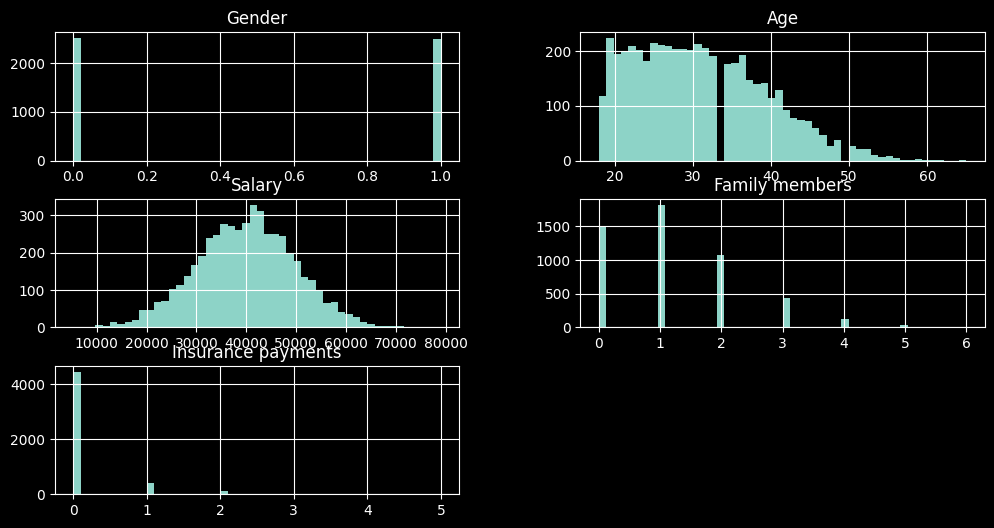

In [36]:
df.hist(bins=50, figsize=(12, 6));

The data is examined.There are no passes, no anamalies were found, with data you can work

## Multiplication of matrices

Designations:

- $ x $ - a matrix of signs (the zero column consists of units)

- $ y $ - vector of the target sign

- $ p $ is a matrix, which is multiplied by signs

- $ w $ - vector of linear regression weights (zero element is equal to the shift)

Predictions:

$$
A = XW
$$

The task of learning:

$$
w = \arg\min_w MSE(Xw, y)
$$


Learning formula:

$$
w = (X^T X)^{-1} X^T y
$$

** Question: ** Signs multiply by the reversible matrix.Will the quality of linear regression change?(It can be taught again.)
- a.Change.Give examples of matrices.
- b.It will not change.Indicate how the parameters of linear regression are related in the initial task and in the transformed.

**Answer:**
- b.It will not change.

**justification:**

Signs of $X$ are multiplying by reversible mattra $O$, denot the result as $M$

$$ M = XO $$

We calculate what the predictions will be equal to the replacement of $X$ by $M$

$$ a_1 = Mw_1 $$

The task of learning will look like this:

$$ w_1 = (M^TM)^{-1} M^Ty $$

To justify, we need to understand the following properties of matrices:

$$ (AB)^{-1} = B^{-1}A^{-1} $$
$$ (ABC)^{-1} = C^{-1} B^{-1} A^{-1} $$
$$ (AB)^T = B^TA^T $$
$$ AA^{-1} = A^{-1} A = E $$ 
$$ AE = EA = A $$ 

Now we will present our prediction formula with the replacement of the parameters, but in full

$$ w_1 = ((XO)^TXO)^{-1} (XO)^Ty $$

Using the above properties of matrices, we will alternately open the brackets

$$ w_1 = ((XO)^TXO)^{-1}(XO)^Ty = (O^TX^TXO)^{-1}O^TX^Ty = O^{-1}(X^T X)^{-1}(O^T)^{-1}O^TX^Ty $$

Next, reduce $(O^T)^{-1}O^T$

$$ w_1 = O^{-1}(X^T X)^{-1}X^Ty $$

You may notice that in the right side of the formula we received $(X^T X)^{-1}X^Ty$, which is a formula for learning $w$

$$ w_1 = O^{-1}w $$

respectively

$$ a_1 = Mw_1 $$

We substitute $ xo $ instead of $ m $, reverse matrices are reduced

$$ a_1 = XOO^{-1}w = Xw = a $$

$$ a_1 = a $$

Q.E.D.From the demonstrated clearly shows why the reversibility of the matrix is ​​a prerequisite

## transformation algorithm

**Algorithm**

1. Generate the random square matrix $O$ dimensions in width of our signs
2. Check the matrix $O$ for reversibility (in case of irreversibility of the matrix, repeat the step 1)
3. Lost our signs $X$ per matrix $O$ $(M = XO)$
4. We apply the transformed parameters in the future algorithm

**rationale**

The dimension of the matrix $O$ should be $(n, n)$, at $n$ equal to the number of signs.Then the $M$ matrix will be the same dimension as the matrix of the original signs of $X$. The reverse matrix exists only for the square unpertured matrices (the determinant of which is not equal to zero).

Consider the example:

In [37]:
np.random.seed(1337)
X = np.random.randint(1,10,(6,3))
O = np.random.randint(1,10,(3,3))
M = X @ O

print('Matrix X')
print(X)
print()
print('Matrix O')
print(O)
if np.linalg.det(O) != 0:
    print('Matrix determinant =', np.linalg.det(O))
    print('The matrix is ​​invertible')
else:
    print('Matrix determinant =', np.linalg.det(O))
    print('The matrix not ​​invertible')
print()
print('Matrix M')
print(M)

Matrix X
[[8 9 8]
 [8 3 3]
 [5 9 7]
 [7 8 9]
 [2 7 7]
 [3 3 9]]

Matrix O
[[2 8 4]
 [2 4 4]
 [5 9 9]]
Matrix determinant = 8.000000000000002
The matrix is ​​invertible

Matrix M
[[ 74 172 140]
 [ 37 103  71]
 [ 63 139 119]
 [ 75 169 141]
 [ 53 107  99]
 [ 57 117 105]]


In [38]:
np.random.seed(1337)
y = np.array([1,2,3,4,5,6])
w = np.linalg.inv(X.T @ X) @ X.T @ y
a = X @ w
w1 = np.linalg.inv(M.T @ M) @ M.T @ y
a1 = M @ w1

print('Target features', y)
print('Feature weight', w)
print('Prediction', a)
print('Encrypted feature weight', w1)
print('Prediction from encrypted features', a1)
print()
print('We check at different stages of formula transformation. If they are equal, then everything is correct')
print('Encrypted feature weight')
print(w1)
print(np.linalg.inv(M.T @ M) @ M.T @ y)
print(np.linalg.inv(((X @ O).T) @ (X @ O)) @ (X @ O).T @ y)
print(np.linalg.inv(O.T @ X.T @ X @ O) @ O.T @ X.T @ y)
print(np.linalg.inv(O) @ np.linalg.inv(X.T @ X) @ np.linalg.inv(O.T) @ O.T @ X.T @ y)
print(np.linalg.inv(O) @ np.linalg.inv(X.T @ X) @ X.T @ y)
print(np.linalg.inv(O) @ w)

Target features [1 2 3 4 5 6]
Feature weight [-0.13494351 -0.28343227  0.8210042 ]
Prediction [2.93759511 0.53316771 2.52142144 4.1769751  3.49311652 6.13391048]
Encrypted feature weight [ 2.91745361  0.03712219 -1.56670706]
Prediction from encrypted features [2.93759511 0.53316771 2.52142144 4.1769751  3.49311652 6.13391048]

We check at different stages of formula transformation. If they are equal, then everything is correct
Encrypted feature weight
[ 2.91745361  0.03712219 -1.56670706]
[ 2.91745361  0.03712219 -1.56670706]
[ 2.91745361  0.03712219 -1.56670706]
[ 2.91745361  0.03712219 -1.56670706]
[ 2.91745361  0.03712219 -1.56670706]
[ 2.91745361  0.03712219 -1.56670706]
[ 2.91745361  0.03712219 -1.56670706]


## Checking the algorithm

In [39]:
X = df.drop('Insurance payments', axis=1)
y = df['Insurance payments']

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.25, random_state=1337)

print('Training sample size:')
print(f'features {X_train.shape};')
print(f'target feature {y_train.shape}')
print(f'It is {round((y_train.count() / y.count()) * 100)}% of dataset')
print()
print('Test sample size:')
print(f'features {X_test.shape};')
print(f'target feature {y_test.shape}')
print(f'It is {round((y_test.count() / y.count()) * 100)}% of the dataset')

Training sample size:
features (3750, 4);
target feature (3750,)
It is 75% of dataset

Test sample size:
features (1250, 4);
target feature (1250,)
It is 25% of the dataset


In [40]:
class LinearRegression:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T @ X) @ X.T @ y
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

In [41]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
score = r2_score(y_test, pred)

print('R2 score of model =', round(score, 2))


R2 score of model = 0.43


Let's write the data encryption formula

In [42]:
def crypto(X):
    n = X.shape[1]
    np.random.seed(1337)
    crypto_mx = np.random.randint(1, 10, (n,n))
    det = np.linalg.det(crypto_mx)
    tryes_counter = 0
    while det == 0:
        tryes_counter += 1
        np.random.seed(1337 + tryes_counter)
        crypto_mx = np.random.randint(1, 10, (n,n))
        det = np.linalg.det(crypto_mx)
    crypted_X = X @ crypto_mx
    return crypted_X, crypto_mx

We encrypt our signs and make sure that everything worked out by taking the first lines of the tables and the encryption key

In [43]:
crypted_X, crypto_mx = crypto(X)

print('Features before encryption')
display(X.head())
print()
print('Features after encryption')
display(crypted_X.head())
print()
print('matrix/encryption key')
crypto_mx

Features before encryption


,Gender,Age,Salary,Family members
0,1,41.00,49600.00,1
1,0,46.00,38000.00,1
2,0,29.00,21000.00,0
3,0,21.00,41700.00,2
4,1,28.00,26100.00,0



Features after encryption


,0,1,2,3
0,347333.00,347339.00,397020.00,446780.00
1,266140.00,266145.00,304237.00,342417.00
2,147087.00,147087.00,168145.00,189261.00
3,291967.00,291977.00,333719.00,375495.00
4,182792.00,182793.00,208948.00,235160.00



matrix/encryption key


array([[8, 9, 8, 8],
       [3, 3, 5, 9],
       [7, 7, 8, 9],
       [2, 7, 7, 3]])

In [44]:
crypted_X_train, crypted_X_test, y_train, y_test = train_test_split(
        crypted_X, y, test_size=0.25, random_state=1337)

model = LinearRegression()
model.fit(crypted_X_train, y_train)
pred = model.predict(crypted_X_test)
crypted_score = r2_score(y_test, pred)

print('R2 score of model =', round(crypted_score, 2))

R2 score of model = 0.43


In [45]:
scores_names = ['data', 
                'crypted data'  
               ]
scores = [score,
          crypted_score
         ]

results = pd.DataFrame({'type':scores_names,
                        'R2 score':crypted_score
                        })

## Conclusion

The stages passed:
- data loaded and studied
- Theoretically substantiated that when multiplying data by a reversible matrix, the quality of linear regression will not change
- The data transformation algorithm is proposed
- The data transformation algorithm is proposed
- the algorithm is tested in practice and showed that theoretical is true

In [46]:
print('Features before encryption')
display(X.head())
print()
print('Features after encryption')
display(crypted_X.head())

results

Features before encryption


,Gender,Age,Salary,Family members
0,1,41.00,49600.00,1
1,0,46.00,38000.00,1
2,0,29.00,21000.00,0
3,0,21.00,41700.00,2
4,1,28.00,26100.00,0



Features after encryption


,0,1,2,3
0,347333.00,347339.00,397020.00,446780.00
1,266140.00,266145.00,304237.00,342417.00
2,147087.00,147087.00,168145.00,189261.00
3,291967.00,291977.00,333719.00,375495.00
4,182792.00,182793.00,208948.00,235160.00


,type,R2 score
0,data,0.43
1,crypted data,0.43


As can be seen, the metric R2 is the same in both cases, and user data is reliably encrypted